#### Loan Default Prediction with Machine Learning

Improving Accuracy and Class Balancing

Final Part of the Case Study.
We built two separate models: a Logisitc Regression and a Random Forest

'Abstract'
This notebook focuses on improving loan default prediction performance by addressing 
class imbalance, where default cases represent only ~21% of the data. Various techniques 
are explored, including class weighting (balanced, manual), resampling (upsampling and 
downsampling), and SMOTE to equalize class representation. Each method is evaluated using 
a custom eval_model() function measuring accuracy, precision, recall, and AUC. 

Among all methods tested, downsampling the majority class yielded the most balanced 
and effective model results.


In [13]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed May  1 18:42:29 2024

@author: Felipe J.

Loan Default Prediction with ML pt. 7, 

Improving Accuracy and Class Balancing.
"""
# All previous excercises point to an underlying attribute: we have an inbalanced data set.
# Our model is having a hard time separating classes since there's very few loan defualts compared to non-defualts.

# We can check loan_df['LOAN_DEFAULT].value_counts() to validate, only 21% of our data is loan-default.

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_confusion_matrix, confusion_matrix, roc_curve, auc 

from imblearn.over_sampling import SMOTE
from sklearn.utils import resample

loan_df = pd.read_csv('/Users/pjaram84/Desktop/Independent Pursuits/Machine Learning with CFI/Loan Default Prediction ML/data/vehicle_loans_feat.csv', index_col='UNIQUEID')


#### Bring Reusable Fucntions (Code) from Feature Eng. and Model Evaluation 

In [14]:
#%% Bring Reusable Fucntions from other Chapters (Model Evaluation & Encode and Split).
def eval_model(model_name, x_test, y_test):  # Takes inputs model_name, x_test data, and y_test data.
    predictions = model_name.predict(x_test) # Predicted Values
    probs = model_name.predict_proba(x_test) # Predicted Probabilities 
    
    # Metrics (Scores)
    accuracy = model_name.score(x_test, y_test)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions) 
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("f1 score:", f1)
    
    # Confusion Matrix
    conf_mat = confusion_matrix(y_test, predictions)
    plot_confusion_matrix(model_name, x_test, y_test)
    
    tn = conf_mat[0][0]  # True Negatives 
    fp = conf_mat[0][1]  # False Positives
    fn = conf_mat[1][0]  # False Negatives 
    tp = conf_mat[1][1]  # True Positives
    print ("True Negatives (Correct Non-Defaults):", tn)    # print True Negatives
    print ("False Positives (Incorrect Defaults):", fp)     # print False Positives
    print ("False Negatives (Incorrect Non-Defaults):", fn) # print False Negatives
    print ("True Positives (Correct Defaults):", tp) 
    
    # The ROC curve
    probs_df = pd.DataFrame()            # Probability 'probs' (0 or 1) dataframe.
    probs_df['Prob. (0)'] = probs[:, 0]     
    probs_df['Prob. (1)'] = probs[:, 1] 
    print(probs_df.describe())           # Descirptive Stats for out Probability for (0 or 1)
    
    fpr, tpr, threshold = roc_curve(y_test, probs[:, 1], pos_label=1) # Generate ROC curve
    roc_auc = auc(fpr, tpr)              # auc() function (area under curve).
    print("Arean under ROC curve (AUC):", roc_auc)
    
    plt.figure(2)                        # Plotting ROC Graph
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (AUC = %0.2f)' % roc_auc) # Formatted to Plot our roc_auc value.
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='TPR=FPR line')      # Line where TPR=FPR.
    plt.xlim([0, 1])                     # "fpr"  goes in x-axis. "tpr" goes in y-axis.
    plt.ylim([0, 1])                     # starts at (0, 0) and ends in (1, 1).
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right") 
    plt.show()
    
    # Prediction Percentages
    results_df = pd.DataFrame()                         # Results Dataframe
    results_df['true_class'] = y_test                   # Compares: y_test, predictions, probability for each row. 
    results_df['predicted_class'] = list(predictions)   # Converting our model predictions from array to list.
    results_df['default_prob'] = probs[:, 1]   
    pred_percentages = results_df.groupby('true_class')['predicted_class'].value_counts(normalize=True)
    print("Prediction Percentages (%):", pred_percentages)                        

def encode_and_split(loan_df):
    loan_data_enc = pd.get_dummies(loan_df, prefix_sep='_ _ _', drop_first=True)
    
    X = loan_data_enc.drop(columns=['LOAN_DEFAULT'])
    y = loan_data_enc['LOAN_DEFAULT']
    
    x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=84)
    return x_train, x_test, y_train, y_test

In [15]:
#%% Quickly Build and Eval the previous Model
x_train, x_test, y_train, y_test = encode_and_split(loan_df) # Used our function for Encode and Train/Test/Split

rforest_classifier = RandomForestClassifier(n_estimators=100, max_depth=(15)) # Initialized Classifier w/ specified Hyperparameters.
rforest_classifier.fit(x_train, y_train) # Fit model to our Training Data.
    # eval_model(rforest_classifier, x_test, y_test) # Our best model is having a hard time with class separation. Let's approach this.

RandomForestClassifier(max_depth=15)

#### Class Balancing Techniques

Accuracy: 0.6375372606206172
Precision: 0.2996826889176166
Recall: 0.5057516858389528
f1 score: 0.37635598848793445


/Users/pjaram84/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


True Negatives (Correct Non-Defaults): 24629
False Positives (Incorrect Defaults): 11918
False Negatives (Incorrect Non-Defaults): 4984
True Positives (Correct Defaults): 5100
          Prob. (0)     Prob. (1)
count  46631.000000  46631.000000
mean       0.565415      0.434585
std        0.131513      0.131513
min        0.137882      0.014869
25%        0.458086      0.337677
50%        0.554232      0.445768
75%        0.662323      0.541914
max        0.985131      0.862118
Arean under ROC curve (AUC): 0.6356291679402961


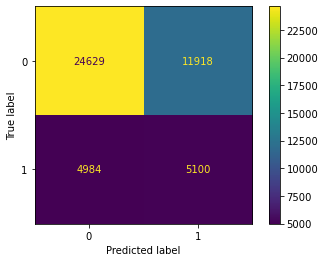

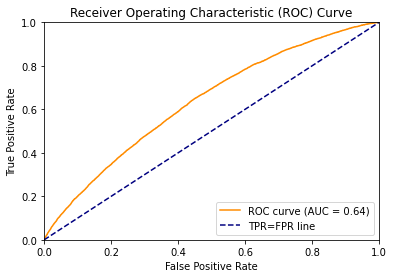

Prediction Percentages (%): true_class  predicted_class
0           0                  0.673899
            1                  0.326101
1           1                  0.505752
            0                  0.494248
Name: predicted_class, dtype: float64


In [16]:
#%% Using Weight Balancing Techniques – Class Balancing             

# Balanced Parameter – By changing the weight, we change the 'influence' that each class has during training phase of model.
rforest_classifier_balanced = RandomForestClassifier(n_estimators=100, max_depth=15, class_weight='balanced') # NOTE: class_weight='balanced' (parameter).
rforest_classifier_balanced.fit(x_train, y_train)

eval_model(rforest_classifier_balanced, x_test, y_test)  # So this model has increased the amount of true defualts predicted. 
                                                         # However, this does come as a cost in Accuracy and Precision.
    # If we look at Predicted Percentages (%)
    # * 66% of no-defaults are correctly predicted                                                  # That is why accuracy and preciosion decreased. 
    # * 32% of no-defaults predictions are wrongfully predicted (were acutally defualts).           # Because eventhough we're catching more defaults, we're 
    # * 50% of default predictions were correctly predicted. (50% chance of getting it right).      # also flagging many non-defaults as defaults.
    # * 49% of default predictions were wrongfully predicted (were not actually defualt).           # Improvement can be seen in the increased Recall score.

Class Balancing – Manual Weighting

In [17]:
# Manual Parameters – Manual Class Weighting
weights = {0:0.27, 1:0.73}                  
rforest_classifier_manualweight = RandomForestClassifier(n_estimators=100, max_depth=15, class_weight=weights) # NOTE: class_weight='balanced' (parameter).
rforest_classifier_manualweight.fit(x_train, y_train)  # Weights should always add up to one
rforest_classifier_manualweight.fit(x_train, y_train)  
'eval_model(rforest_classifier_balanced_manual, x_test, y_test)' # Building ML models involves trade offs.


'eval_model(rforest_classifier_balanced_manual, x_test, y_test)'

Class Balancing – Resampling

In [18]:
#%% Resampling                * Resampling should only ever be done in training data. Not test data.
# Upsampling – Process of resampling minority class to match instances of majority class.
# That is, equal number of default and non-defualt loans.

train_df = x_train.copy()     # copy x_train
train_df['LOAN_DEFAULT'] = y_train
train_df.value_counts(normalize=True) # Check Target Variable Distribution. 78% NonDefault. 21% Defualt.

# Split target variable classes
train_minority = train_df[train_df['LOAN_DEFAULT'] == 1]
train_majority = train_df[train_df['LOAN_DEFAULT'] == 0]

# Perform upsampling
train_minority_up = resample(train_minority, replace=True, n_samples=train_majority.shape[0], random_state=48)
    # Using 'resample()' function.
print(train_minority_up['LOAN_DEFAULT'].value_counts()) # As you can see, no there's equal instances for both.
print(train_majority['LOAN_DEFAULT'].value_counts())
# Awesome, now train_minority_up = train_majority. Only one is for Defualts and the other for NonDefaults.

# Concatenate for Full Training Set
train_upsampled_df = pd.concat([train_majority, train_minority_up])

# Split features from Labels
x_train_up = train_upsampled_df.drop(columns=['LOAN_DEFAULT'])
y_train_up = train_upsampled_df['LOAN_DEFAULT']

# Train and Eval
rforest_classifier_upsampled = RandomForestClassifier()
rforest_classifier_upsampled.fit(x_train_up, y_train_up)
'eval_model(rforest_classifier_upsampled, x_test, y_test)'

# Downsampling – Reducing Majority Class instances to Minority Class.
# Create a function that performs Upsampling or Downsampling automatically based on user input.

def balance_sample(x_train, y_train, sample_mode='up'):
    train_df = x_train.copy()
    train_df['LOAN_DEFAULT'] = y_train
    
    train_minority = train_df[train_df['LOAN_DEFAULT'] == 1]
    train_majority = train_df[train_df['LOAN_DEFAULT'] == 0]
    train_df_sampled = pd.DataFrame()
    
    if sample_mode == 'down':
        train_majority_down = resample(train_majority, replace=False, n_samples=train_minority.shape[0], random_state=123)
        train_sample_df = pd.concat([train_minority, train_majority_down])
    else:
        train_minority_up = resample(train_minority, replace=True, n_samples=train_majority.shape[0], random_state=123)
        train_sampled_df = pd.concat([train_majority,train_minority_up])
   
    x_train_samp = train_sampled_df.drop(columns=['LOAN_DEFAULT'], axis=1)
    y_train_samp = train_sampled_df['LOAN_DEFAULT']
    
    return x_train_samp, y_train_samp

1    145996
Name: LOAN_DEFAULT, dtype: int64
0    145996
Name: LOAN_DEFAULT, dtype: int64


Class Balancing - SMOTE

In [19]:
#%% Synthetic Minority Oversampling Technique SMOTE – 'imblearn' library            # Sampling technique which upsamples minority class by
                                                                           # creating new data points rather than copying existing dates.
smote = SMOTE() # Initialize
x_train_synth, y_train_synth = smote.fit_resample(x_train, y_train)

# Check Distribution of target variable in this new data
print(y_train_synth.value_counts())
print(y_train_synth.value_counts(normalize=True))       # Good. Evenely distributed classes.

# rforest_classifier_smote = RandomForestClassifier(n_estimators=100, max_depth=15)
# rforest_classifier_smote.fit(x_train_synth, y_train_synth)
'eval_model(rforest_classifier_smote, x_test, y_test)'  # To evaluate.


0    145996
1    145996
Name: LOAN_DEFAULT, dtype: int64
0    0.5
1    0.5
Name: LOAN_DEFAULT, dtype: float64


'eval_model(rforest_classifier_smote, x_test, y_test)'

In [20]:
#%% Summary
"""Summary:
This notebook focuses on improving loan default prediction performance by addressing 
class imbalance, where default cases represent only ~21% of the data. Various techniques 
are explored, including class weighting (balanced, manual), resampling (upsampling and 
downsampling), and SMOTE to equalize class representation. Each method is evaluated using
a custom eval_model() function measuring accuracy, precision, recall, and AUC. Among all 
methods tested, downsampling the majority class yielded the most balanced and effective model
results.
"""

'Summary:\nThis notebook focuses on improving loan default prediction performance by addressing \nclass imbalance, where default cases represent only ~21% of the data. Various techniques \nare explored, including class weighting (balanced, manual), resampling (upsampling and \ndownsampling), and SMOTE to equalize class representation. Each method is evaluated using\na custom eval_model() function measuring accuracy, precision, recall, and AUC. Among all \nmethods tested, downsampling the majority class yielded the most balanced and effective model\nresults.\n'